<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, r2_score,mean_squared_error

sns.set_style('ticks')
plt.style.use('seaborn')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
df = pd.read_csv('./housing.csv')
df.shape

(1460, 81)

# 47 'fixed' characteristics features selected to predict SalePrice

In [3]:
fixed_features = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour',
                'Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType',
                'HouseStyle','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                'MasVnrType','MasVnrArea','Foundation','BsmtExposure','TotalBsmtSF', '1stFlrSF','2ndFlrSF',
                'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr', 'KitchenAbvGr',
                'TotRmsAbvGrd','GarageType','GarageCars','GarageArea','PavedDrive','PoolArea',
                'MiscFeature','MiscVal','YrSold','SaleType','SaleCondition','SalePrice']
len(fixed_features)

48

In [4]:
# see overall dimensions of dataframe
df.shape

(1460, 81)

# Create dataframe containing fixed features only

In [5]:
df_fixed = df.loc[:, fixed_features]

# 'MSZoning': Remove non-residentials. Retain FV, RL, RM and RH.

In [6]:
df_fixed['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [7]:
df_fixed = df_fixed[df_fixed['MSZoning'].isin(['RL', 'RM', 'RH', 'FV'])]

In [8]:
df_fixed.shape

(1450, 48)

# EDA: Data Cleaning

In [9]:
# check datatypes
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 48 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-null object
MasVnrType       1442 non-null object
MasVnrArea       1442 no

In [10]:
# see how many null values exist for each feature
df_fixed.isnull().sum().sort_values(ascending=False).head(10)

MiscFeature     1398
Alley           1361
LotFrontage      259
GarageType        79
BsmtExposure      38
MasVnrArea         8
MasVnrType         8
Street             0
BldgType           0
Exterior1st        0
dtype: int64

### MiscFeature:

In [11]:
# Look at the unique values and the count of each of them
df_fixed['MiscFeature'].value_counts()

Shed    47
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

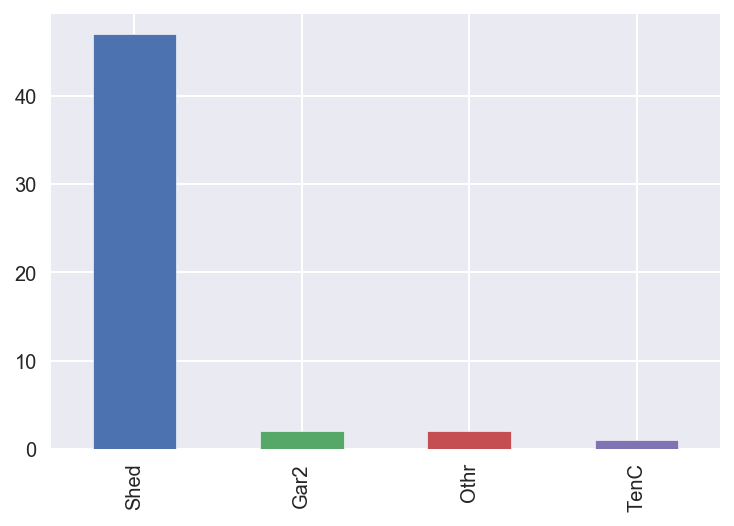

In [12]:
# MiscFeature: Replace 'None' with np.nan
pd.Series(df_fixed['MiscFeature']).value_counts().plot('bar')
df_fixed['MiscFeature'].unique()
df_fixed['MiscFeature'].replace('None', np.nan, inplace=True)

### Alley:

Median SalePrice of nulls: 165400.0


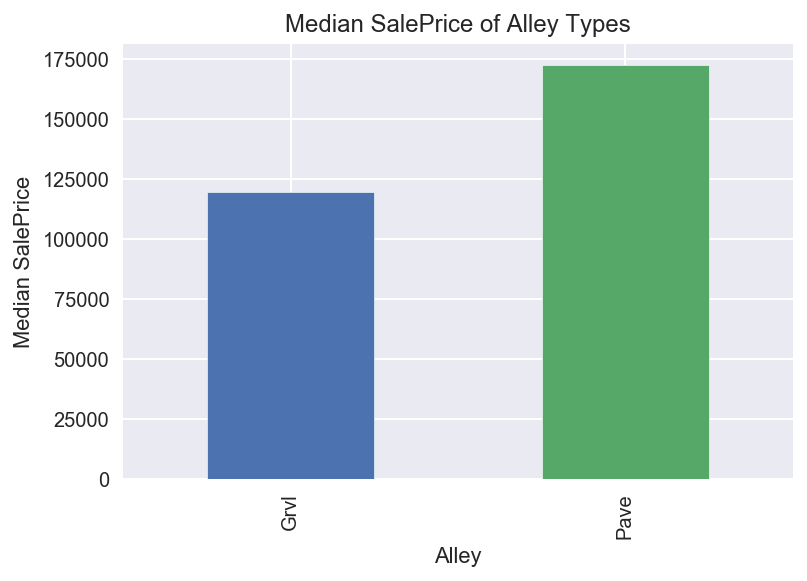

In [13]:
# Grvl, Pave or No Alley (nulls)
# houses with pavement generally more expensive than houses with gravel
df_fixed['SalePrice'].groupby(df_fixed['Alley']).median().plot('bar')
print('Median SalePrice of nulls:', df_fixed[df_fixed['Alley'].isnull()].SalePrice.median())
plt.title('Median SalePrice of Alley Types')
plt.ylabel('Median SalePrice')
plt.show()

### LotFrontage:

In [14]:
# histogram to see distribution
df_fixed['LotFrontage'].describe()

count    1191.000000
mean       70.052897
std        24.301013
min        21.000000
25%        59.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

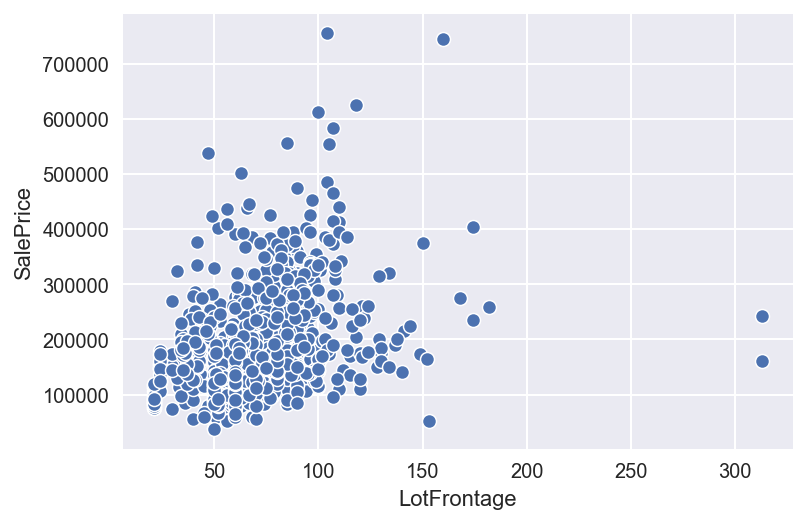

In [15]:
sns.scatterplot(df_fixed['LotFrontage'], df_fixed['SalePrice'])

In [16]:
# LotFrontage (continuous): Null values represents a lack of frontage. Replace them with 0
df_fixed['LotFrontage'].replace(np.nan, 0, inplace=True)

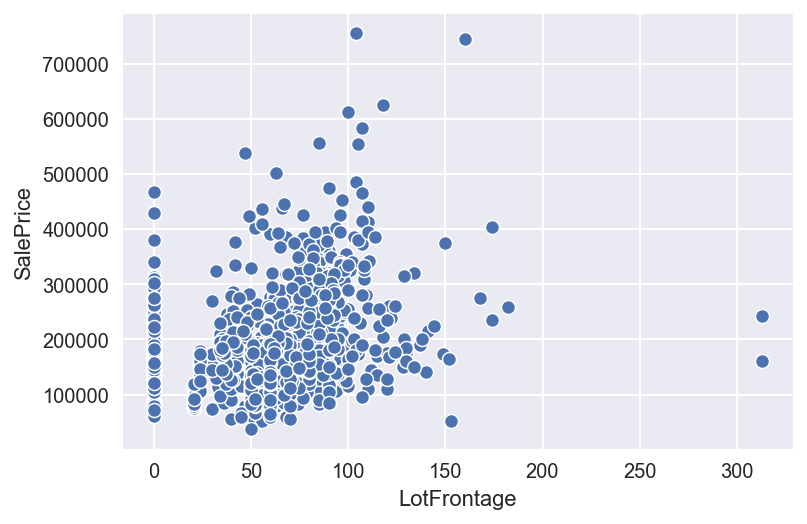

In [17]:
# look at scatter again
sns.scatterplot(df_fixed['LotFrontage'], df_fixed['SalePrice'])

In [18]:
# # create new feature Frontage. if LotFrontage is null label as 0, else 1
# df_fixed['Frontage'] = np.where(pd.isnull(df_fixed['LotFrontage']), 0, 1)
# df_fixed['Frontage'].unique()

### GarageType:

In [19]:
df_fixed['GarageType'].value_counts()

Attchd     870
Detchd     381
BuiltIn     88
Basment     18
CarPort      8
2Types       6
Name: GarageType, dtype: int64

Mean SalePrice of nulls: 104415.18987341772


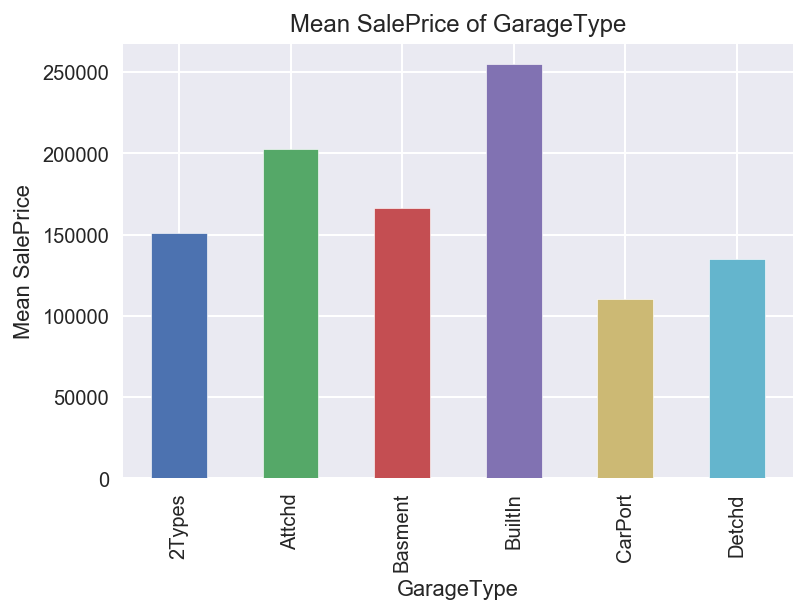

In [20]:
# average SalePrice of having any type of garage is higher than having no garage
df_fixed['SalePrice'].groupby(df_fixed['GarageType']).mean().plot('bar')
print('Mean SalePrice of nulls:', df_fixed[df_fixed['GarageType'].isnull()].SalePrice.mean())
plt.ylabel('Mean SalePrice')
plt.title('Mean SalePrice of GarageType')
plt.show()

In [21]:
# # replace 'None' with np.nan
# pd.Series(df_fixed['GarageType']).value_counts().plot('bar')
# df_fixed['GarageType'].replace('None', np.nan, inplace=True)

### BsmtExposure:

In [22]:
df_fixed['BsmtExposure'].value_counts()

No    947
Av    219
Gd    134
Mn    112
Name: BsmtExposure, dtype: int64

Mean SalePrice of nulls: 107938.34210526316


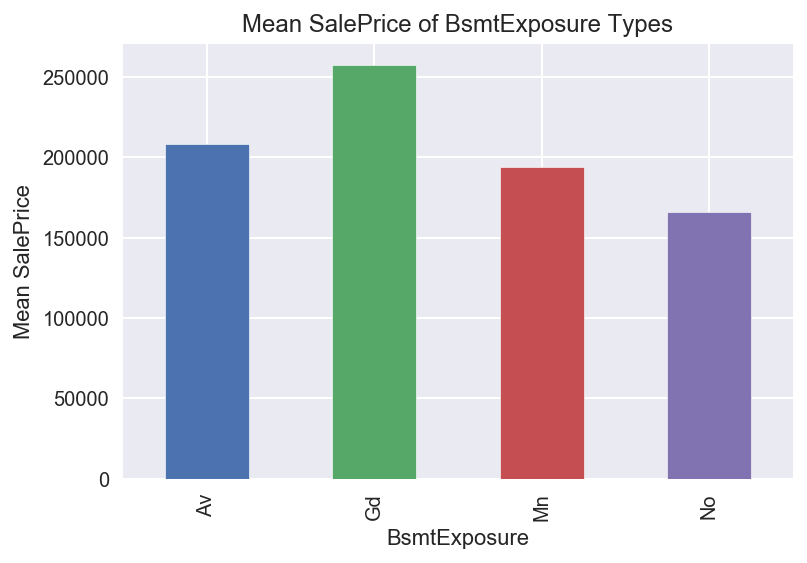

In [23]:
# average SalePrice of having any sort of basement exposure is higher than that of not having basement
df_fixed['SalePrice'].groupby(df_fixed['BsmtExposure']).mean().plot('bar')
print('Mean SalePrice of nulls:', df_fixed[df_fixed['BsmtExposure'].isnull()].SalePrice.mean())
plt.title('Mean SalePrice of BsmtExposure Types')
plt.ylabel('Mean SalePrice')
plt.show()

### MasVnrType:

In [24]:
df_fixed['MasVnrType'].value_counts()

None       854
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Mean SalePrice of nulls: 236484.25


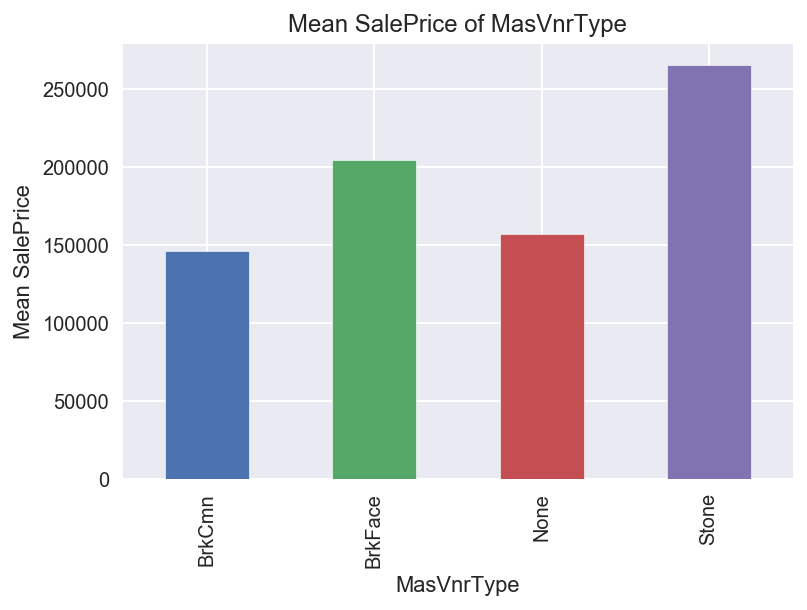

In [25]:
df_fixed['SalePrice'].groupby(df_fixed['MasVnrType']).mean().plot('bar')
print('Mean SalePrice of nulls:', df_fixed[df_fixed['MasVnrType'].isnull()].SalePrice.mean())
plt.title('Mean SalePrice of MasVnrType')
plt.ylabel('Mean SalePrice')
plt.show()

In [26]:
# Replace 'None' with np.nan
df_fixed['MasVnrType'].replace('None', np.nan, inplace=True)

### MasVnrArea:

In [27]:
df_fixed['MasVnrArea'].describe()

count    1442.000000
mean      104.404300
std       181.486539
min         0.000000
25%         0.000000
50%         0.000000
75%       166.750000
max      1600.000000
Name: MasVnrArea, dtype: float64

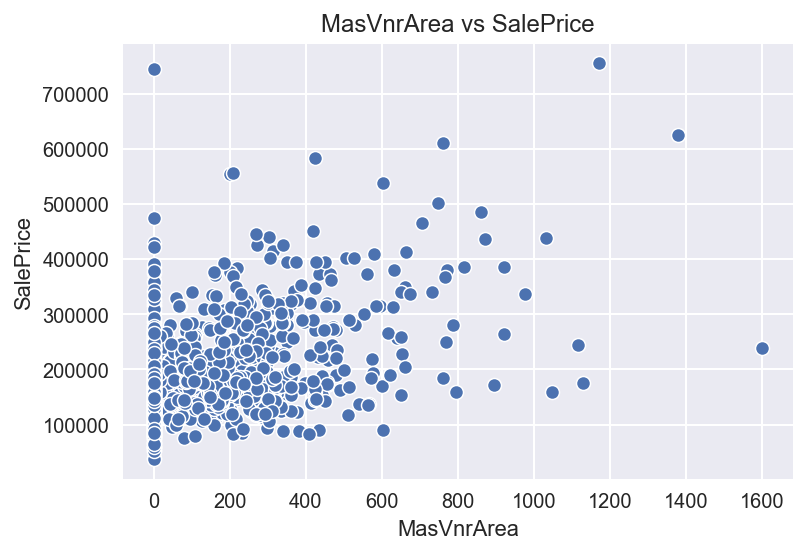

In [28]:
sns.scatterplot(df_fixed['MasVnrArea'], df_fixed['SalePrice'])
plt.title('MasVnrArea vs SalePrice')
plt.show()

In [29]:
# Replace null with 0
df_fixed['MasVnrArea'].replace(np.nan, 0, inplace=True)

In [30]:
df_fixed.describe()

MSSubClass  LotFrontage        LotArea    YearBuilt  YearRemodAdd  \
count  1450.000000   1450.00000    1450.000000  1450.000000   1450.000000   
mean     56.903448     57.54000   10523.831724  1971.593103   1985.049655   
std      42.265033     34.71992   10012.185355    30.022696     20.552319   
min      20.000000      0.00000    1300.000000  1872.000000   1950.000000   
25%      20.000000     41.25000    7544.500000  1954.000000   1967.000000   
50%      50.000000     63.00000    9496.000000  1973.000000   1994.000000   
75%      70.000000     79.00000   11613.500000  2001.000000   2004.000000   
max     190.000000    313.00000  215245.000000  2010.000000   2010.000000   

        MasVnrArea  TotalBsmtSF     1stFlrSF     2ndFlrSF    GrLivArea  \
count  1450.000000  1450.000000  1450.000000  1450.000000  1450.000000   
mean    103.828276  1059.408966  1164.773103   347.394483  1517.698621   
std     181.150114   439.207322   386.646095   437.094261   525.154207   
min       0.000000     0.000000   334.000000     0.000000   334.000000   
25%       0.000000   796.000000   882.500000     0.000000  1131.250000   
50%       0.000000   992.000000  1088.000000     0.000000  1466.000000   
75%     166.000000  1301.500000  1392.000000   728.000000  1779.000000   
max    1600.000000  6110.000000  4692.000000  2065.000000  5642.000000   

           ...           HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
count      ...        1450.000000   1450.000000   1450.000000   1450.000000   
mean       ...           0.384828      2.870345      1.046207      6.522069   
std        ...           0.503450      0.814645      0.219643      1.625324   
min        ...           0.000000      0.000000      0.000000      2.000000   
25%        ...           0.000000      2.000000      1.000000      5.000000   
50%        ...           0.000000      3.000000      1.000000      6.000000   
75%        ...           1.000000      3.000000      1.000000      7.000000   
max        ...           2.000000      8.000000      3.000000     14.000000   

        GarageCars   GarageArea     PoolArea       MiscVal       YrSold  \
count  1450.000000  1450.000000  1450.000000   1450.000000  1450.000000   
mean      1.770345   473.277931     2.777931     43.365517  2007.812414   
std       0.745136   212.687621    40.315051    497.636495     1.326321   
min       0.000000     0.000000     0.000000      0.000000  2006.000000   
25%       1.000000   336.000000     0.000000      0.000000  2007.000000   
50%       2.000000   480.000000     0.000000      0.000000  2008.000000   
75%       2.000000   576.000000     0.000000      0.000000  2009.000000   
max       4.000000  1418.000000   738.000000  15500.000000  2010.000000   

           SalePrice  
count    1450.000000  
mean   181654.942069  
std     79176.485241  
min     37900.000000  
25%    130000.000000  
50%    163945.000000  
75%    214000.000000  
max    755000.000000  

[8 rows x 23 columns]

# Numerical features: check correlation against SalePrice

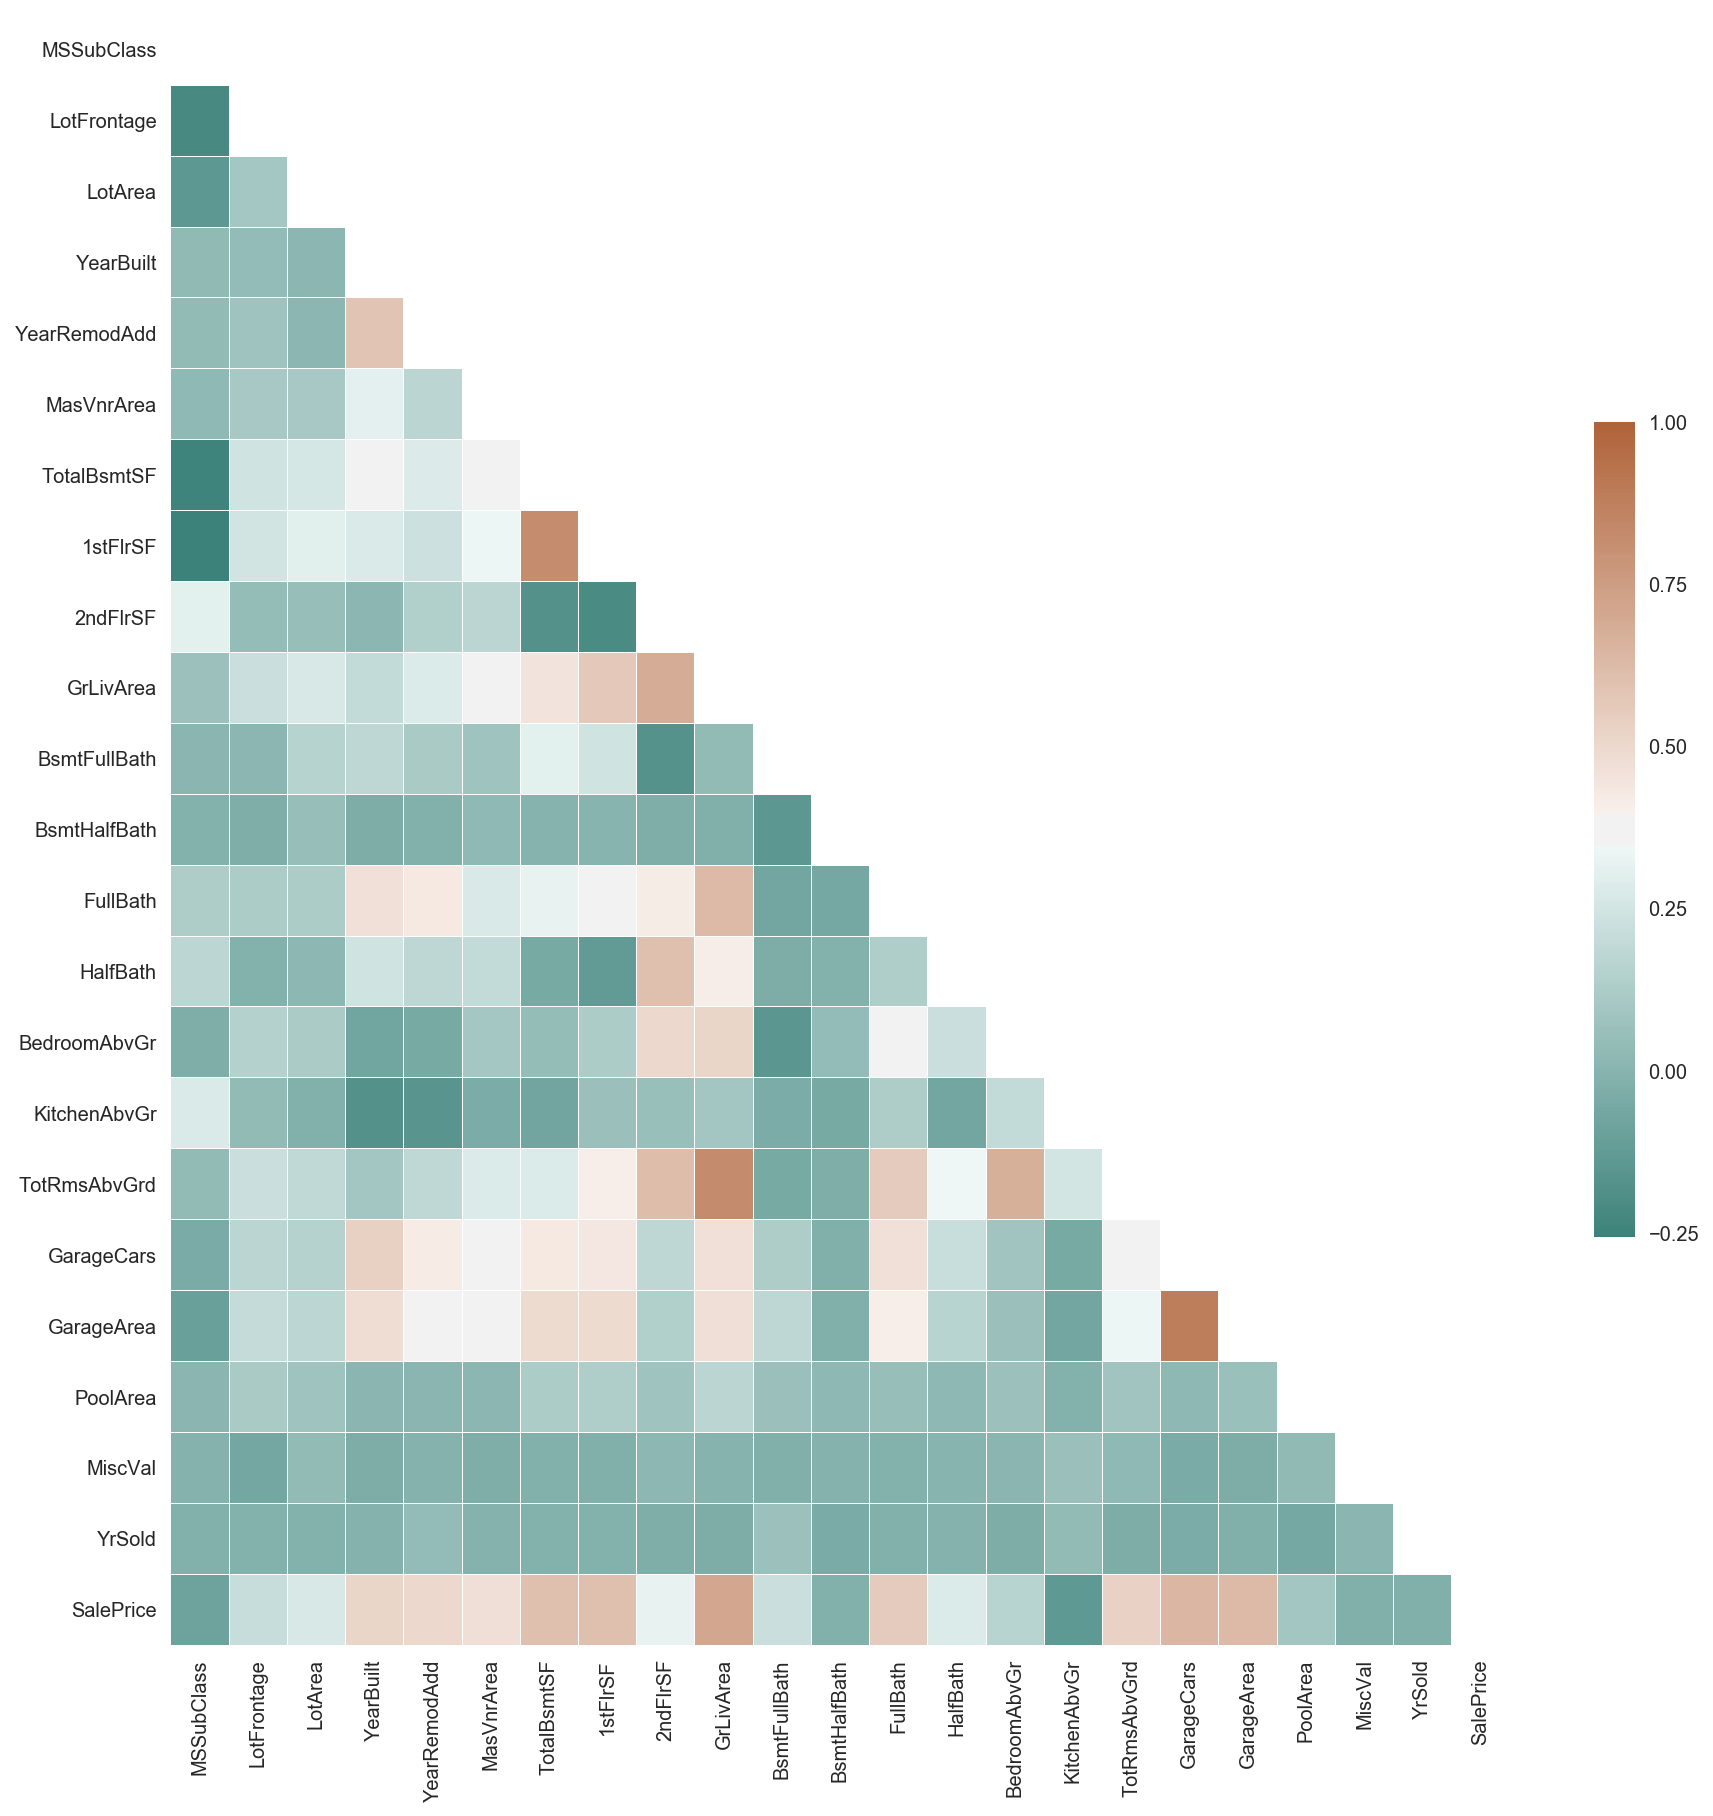

In [31]:
# use heatmap to look at correlation of continuous variables in df_fixed
mask = np.zeros_like(df_fixed.corr())
mask[np.triu_indices_from(mask)]=True
cmap = sns.diverging_palette(180, 30, as_cmap=True)
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(15,15))
    heat=sns.heatmap(df_fixed.corr(), mask=mask, cmap=cmap, cbar_kws={'shrink':.5}, linewidth=.01);
       
fig=heat.get_figure()

In [32]:
# look at absolute correlation with respect to SalePrice
corr_list = df_fixed.corr()
corr_list['SalePrice'].abs().sort_values(ascending=False)

SalePrice       1.000000
GrLivArea       0.708658
GarageCars      0.642135
GarageArea      0.629831
TotalBsmtSF     0.612088
1stFlrSF        0.603300
FullBath        0.556674
TotRmsAbvGrd    0.533355
YearBuilt       0.517602
YearRemodAdd    0.501186
MasVnrArea      0.471056
2ndFlrSF        0.319774
HalfBath        0.280882
LotArea         0.264715
BsmtFullBath    0.224054
LotFrontage     0.214273
BedroomAbvGr    0.162008
KitchenAbvGr    0.137825
PoolArea        0.092396
MSSubClass      0.087487
YrSold          0.025391
MiscVal         0.021052
BsmtHalfBath    0.017561
Name: SalePrice, dtype: float64

In [33]:
# remove those with correlation < 0.2
df_fixed = df_fixed.drop(columns=['BsmtHalfBath', 'MiscVal', 'MSSubClass', 'PoolArea', 'KitchenAbvGr',
                                  'BedroomAbvGr'])

In [34]:
# remaining features
df_fixed.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'TotRmsAbvGrd', 'GarageType', 'GarageCars', 'GarageArea',
       'PavedDrive', 'MiscFeature', 'YrSold', 'SaleType', 'SaleCondition',
       'SalePrice'],
      dtype='object')

# CATEGORICAL FEATURES: CLEAN THEM UP. CHECK IF ANY OF THEM ARE NOT WORTH KEEPING

### Utilities:

In [35]:
df_fixed['Utilities'].value_counts()

AllPub    1449
NoSeWa       1
Name: Utilities, dtype: int64

In [36]:
df_fixed[df_fixed['Utilities'] == 'NoSeWa']

MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour  \
944       RL          0.0    14375   Pave   NaN      IR1         Lvl   

    Utilities LotConfig LandSlope    ...    TotRmsAbvGrd GarageType  \
944    NoSeWa   CulDSac       Gtl    ...               7    Basment   

    GarageCars GarageArea PavedDrive  MiscFeature  YrSold SaleType  \
944          2        525          Y          NaN    2009      COD   

    SaleCondition SalePrice  
944       Abnorml    137500  

[1 rows x 42 columns]

In [37]:
# dont think its gonna value-add. Drop!
df_fixed.drop(columns='Utilities', inplace=True)

### MSZoning:

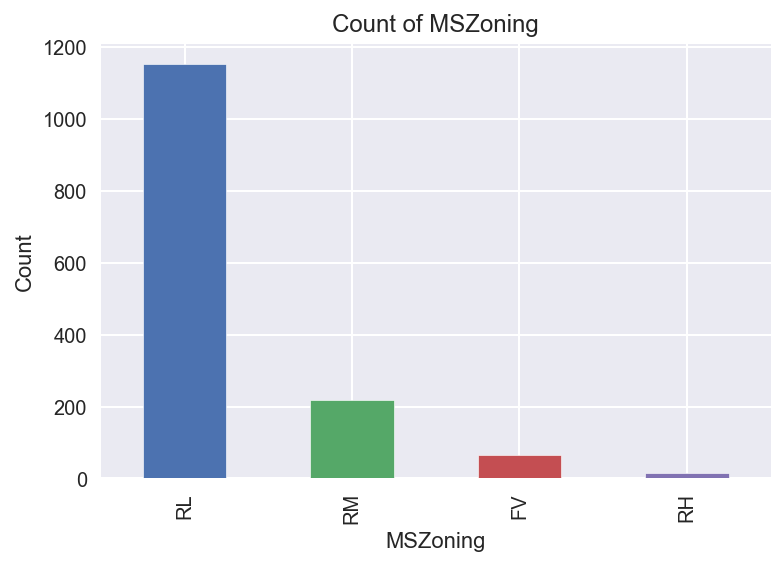

In [38]:
# replace missing values with most common category RL
pd.Series(df_fixed['MSZoning']).value_counts().plot('bar')
df_fixed['MSZoning'] = df_fixed['MSZoning'].fillna(df_fixed['MSZoning'].mode()[0])
plt.title('Count of MSZoning')
plt.ylabel('Count')
plt.xlabel('MSZoning')
plt.show()

### Street:

In [39]:
df_fixed['Street'].value_counts()

Pave    1446
Grvl       4
Name: Street, dtype: int64

In [40]:
df_fixed[df_fixed['Street'] == 'Grvl']

MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour  \
52         RM        110.0     8472   Grvl   NaN      IR2         Bnk   
335        RL          0.0   164660   Grvl   NaN      IR1         HLS   
582        RL         81.0    11841   Grvl   NaN      Reg         Lvl   
1184       RL         50.0    35133   Grvl   NaN      Reg         Lvl   

     LotConfig LandSlope Neighborhood    ...    TotRmsAbvGrd GarageType  \
52      Corner       Mod       IDOTRR    ...               5    CarPort   
335     Corner       Sev       Timber    ...               7     Attchd   
582     Inside       Gtl      Edwards    ...               5        NaN   
1184    Inside       Mod       Timber    ...               5     2Types   

     GarageCars GarageArea  PavedDrive  MiscFeature YrSold SaleType  \
52            2        516           Y          NaN   2010       WD   
335           2        529           Y         Shed   2008       WD   
582           0          0           Y          NaN   2007       WD   
1184          3        995           Y          NaN   2007       WD   

     SaleCondition SalePrice  
52          Normal    110000  
335         Normal    228950  
582         Normal    118500  
1184        Normal    186700  

[4 rows x 41 columns]

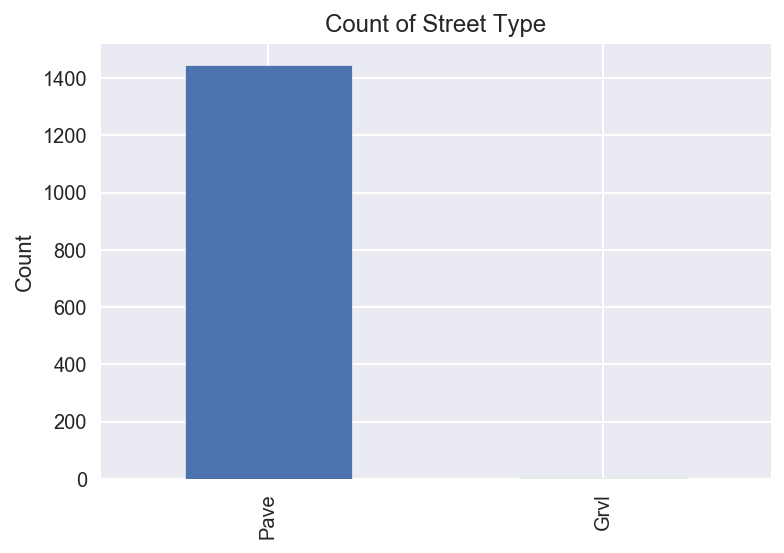

In [41]:
# dont think this will value-add too. Drop!
pd.Series(df_fixed['Street']).value_counts().plot('bar')
df_fixed.drop(columns='Street', inplace=True)
plt.title('Count of Street Type')
plt.ylabel('Count')
plt.show()

# SalePrice:

In [42]:
# Average SalePrice in dataset
df_fixed['SalePrice'].mean()

181654.94206896552

YrSold
2006    183260.317308
2007    186222.185976
2008    178134.751656
2009    180143.306548
2010    179167.000000
Name: SalePrice, dtype: float64


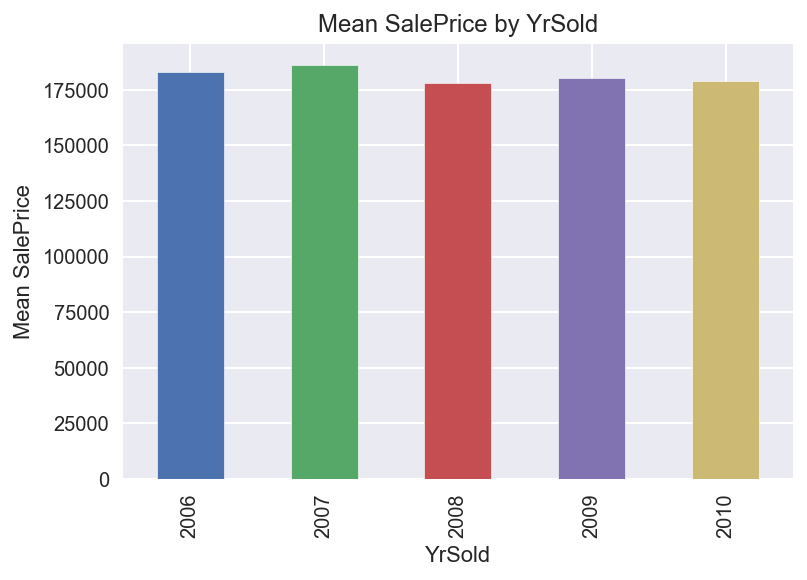

In [43]:
# Average SalePrice by YrSold
avg_price_year = df_fixed['SalePrice'].groupby(df_fixed['YrSold']).mean()
print(avg_price_year)
avg_price_year.plot('bar')
plt.title('Mean SalePrice by YrSold')
plt.ylabel('Mean SalePrice')
plt.show()

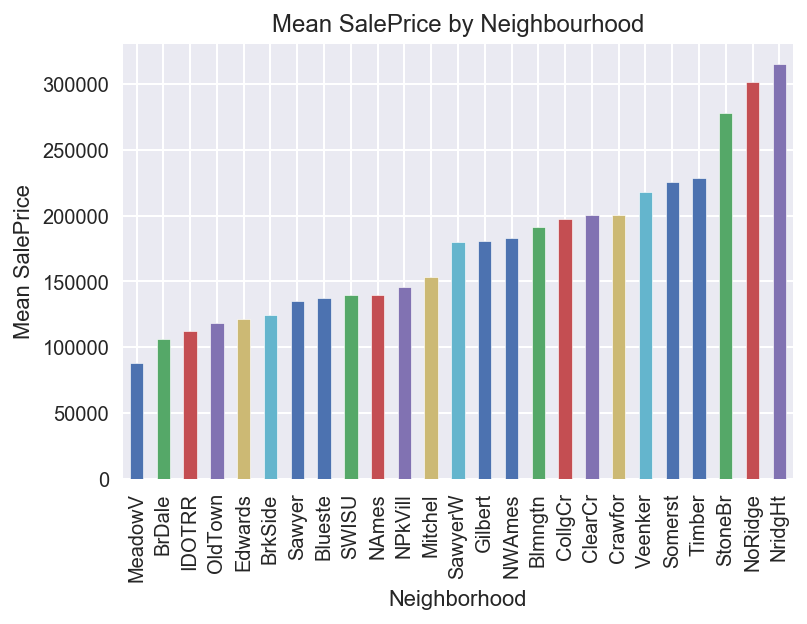

In [44]:
# Median SalePrice by Neighbourhood
df_fixed['SalePrice'].groupby(df['Neighborhood']).median().sort_values().plot('bar')
plt.title('Mean SalePrice by Neighbourhood')
plt.ylabel('Mean SalePrice')
plt.show()

In [45]:
# FINALLY, A TOTAL OF 39 'FIXED' FEATURES
df_fixed.shape

(1450, 40)

### Log Transformation on SalePrice:

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


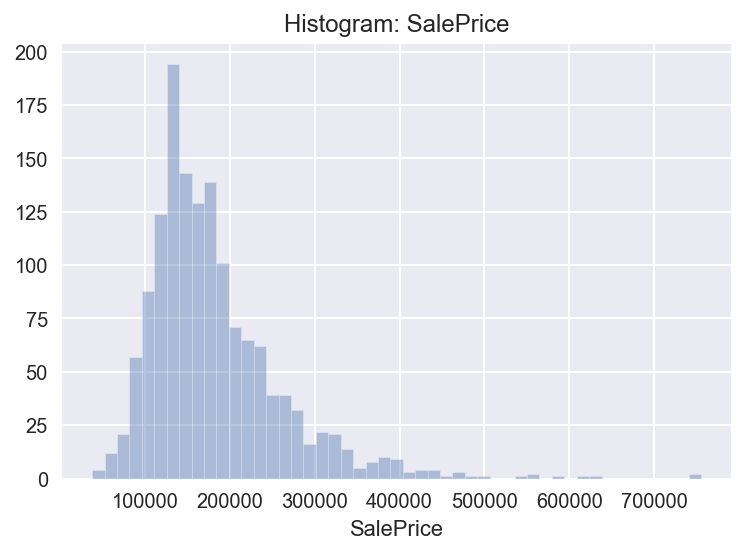

In [46]:
sns.distplot(df_fixed['SalePrice'], kde=False)
plt.title('Histogram: SalePrice')
plt.show()

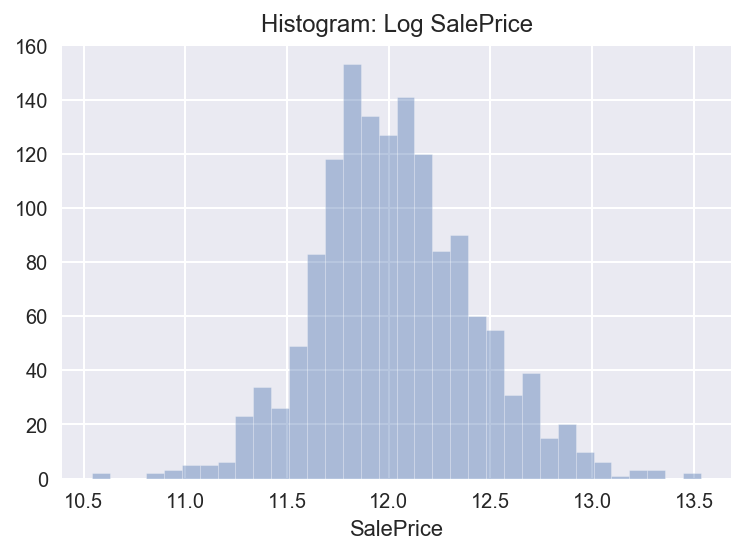

In [47]:
# apply log transformation to SalePrice since its slightly skewed to the right
df_fixed['SalePrice'] = np.log(df_fixed['SalePrice'])
sns.distplot(df_fixed['SalePrice'], kde=False)
plt.title('Histogram: Log SalePrice')
plt.show()

# Distribution of other numerical features

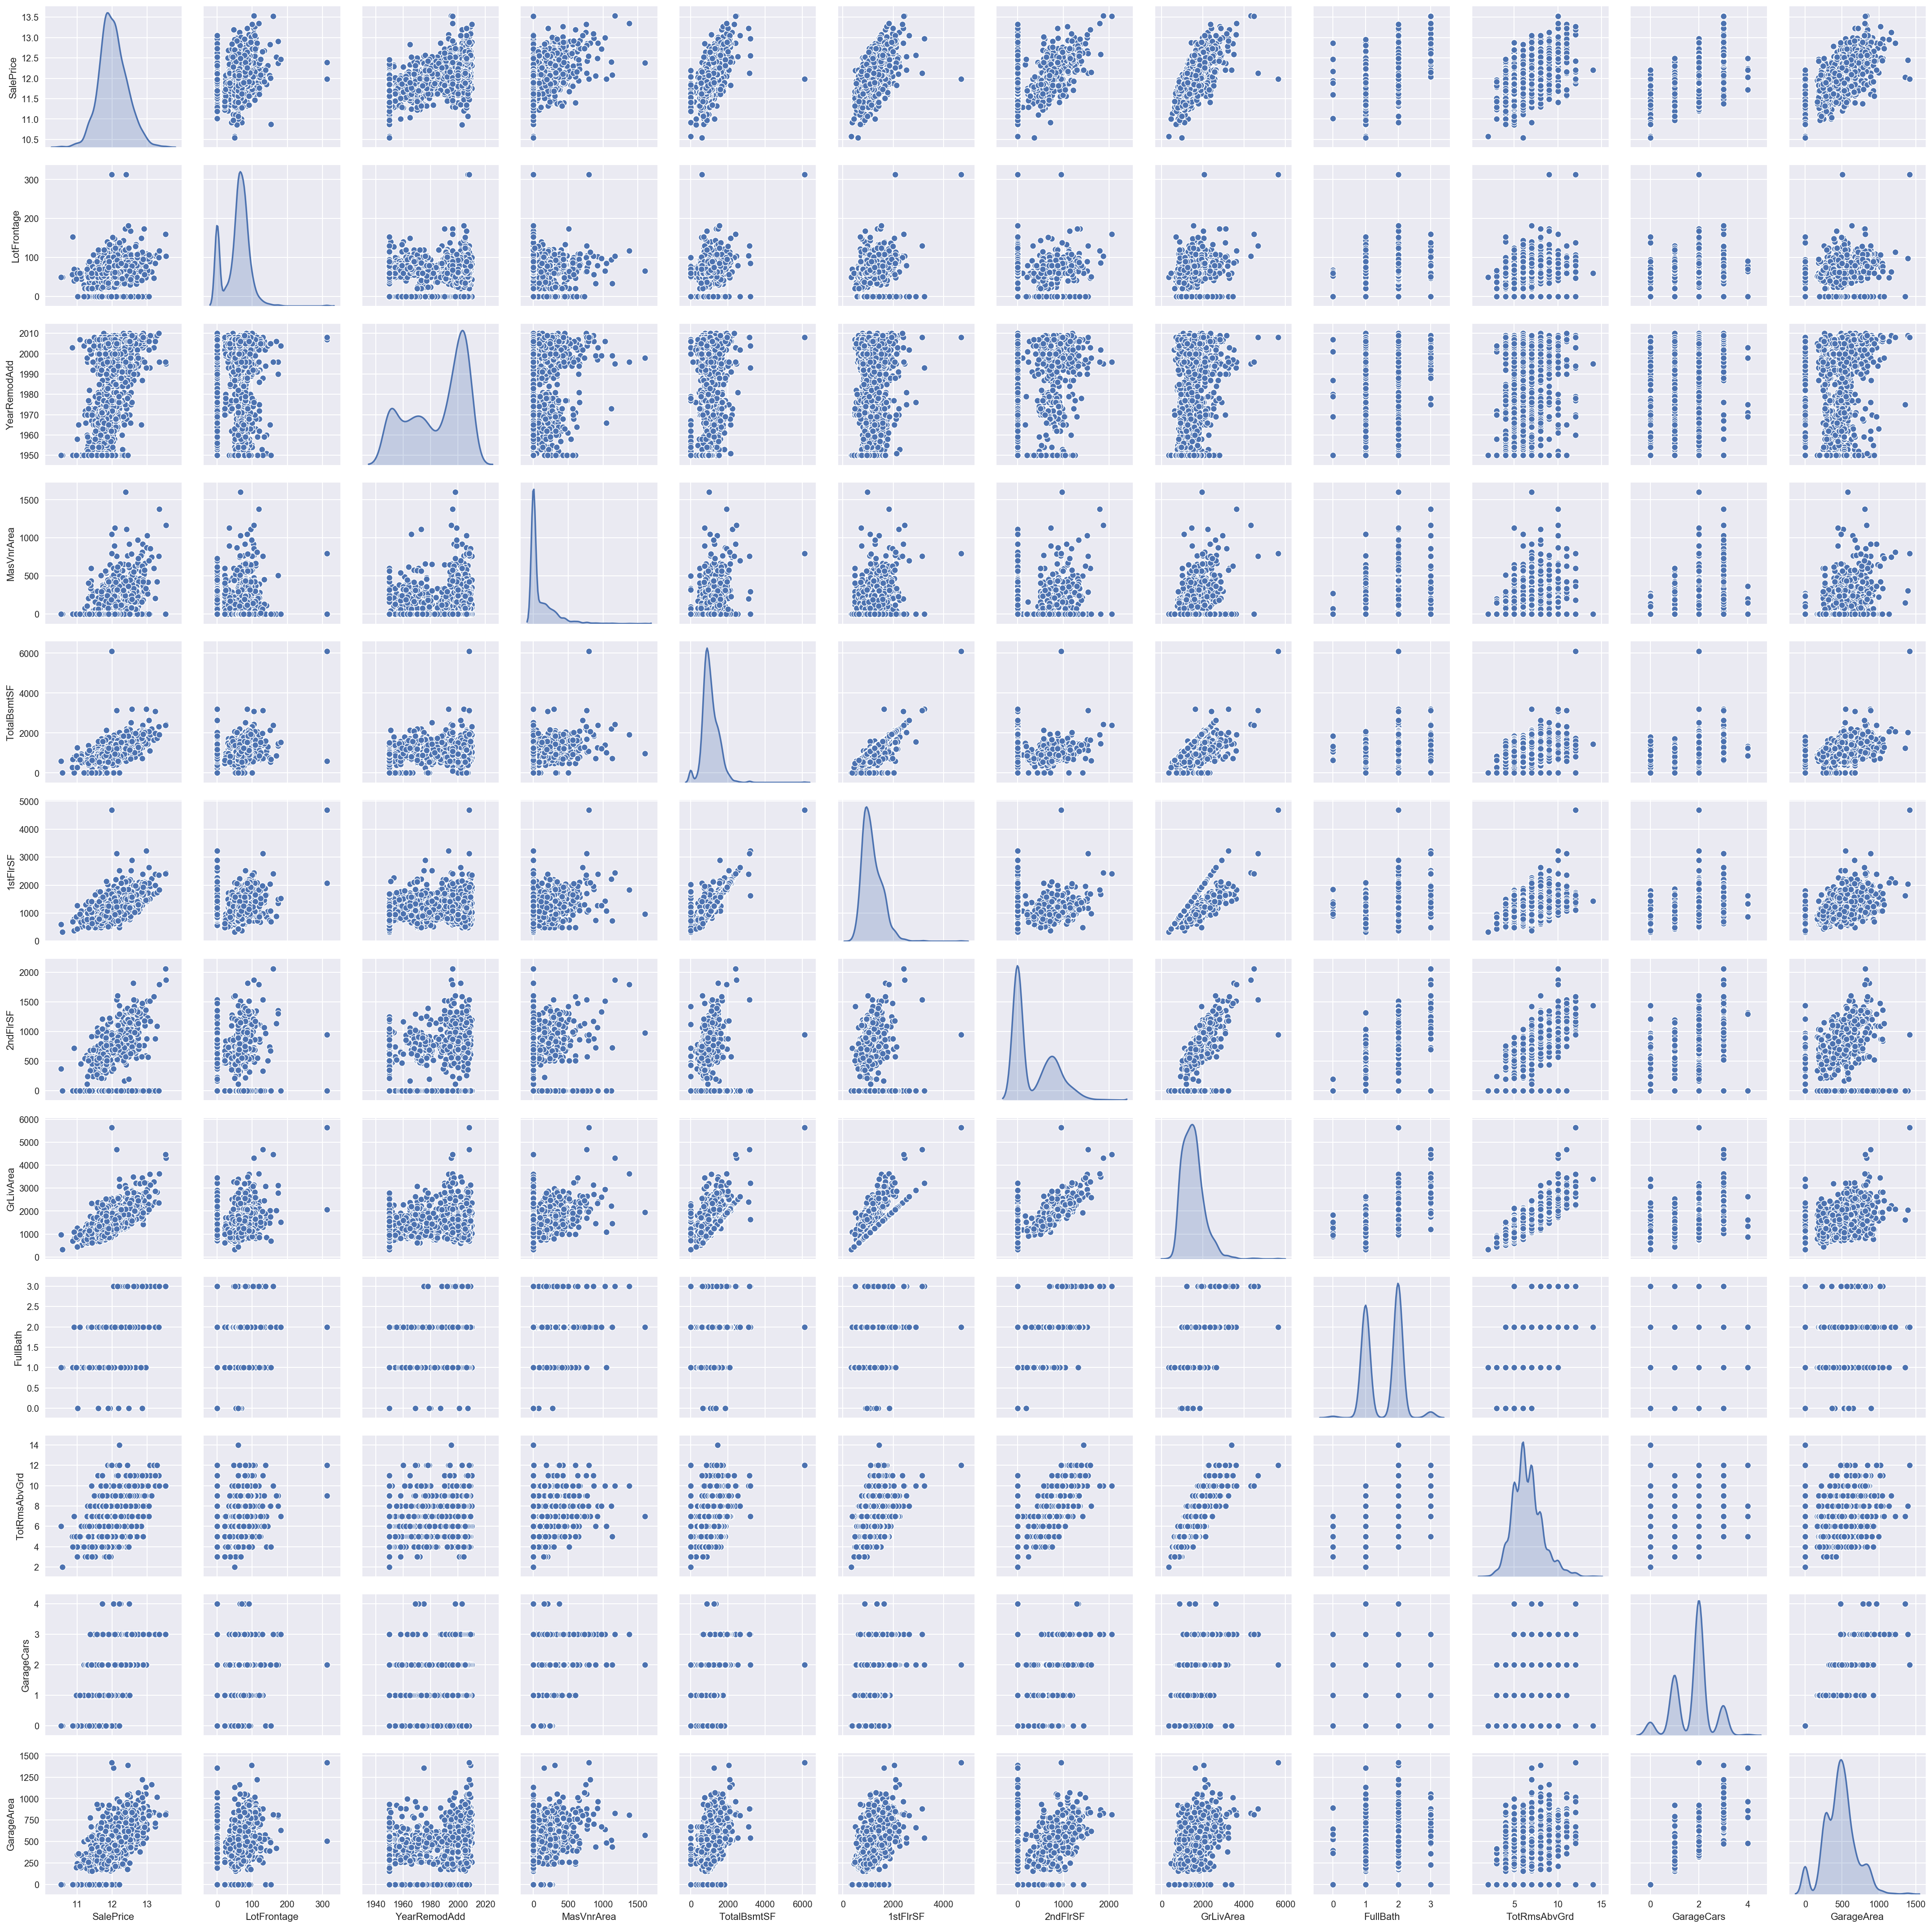

In [48]:
# pairplot on selected numerical features
numerical_plot = ['SalePrice','LotFrontage', 'YearRemodAdd','MasVnrArea','TotalBsmtSF', '1stFlrSF',
                     '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']
sns.pairplot(df_fixed[numerical_plot],diag_kind='kde')
plt.show()

In [49]:
# check skew
skew_feats = df_fixed[numerical_plot].skew().sort_values(ascending=False)
skew_feats

MasVnrArea      2.666948
TotalBsmtSF     1.520615
1stFlrSF        1.377465
GrLivArea       1.373430
2ndFlrSF        0.811506
TotRmsAbvGrd    0.678525
LotFrontage     0.269817
SalePrice       0.235159
GarageArea      0.162739
FullBath        0.037417
GarageCars     -0.342681
YearRemodAdd   -0.514579
dtype: float64

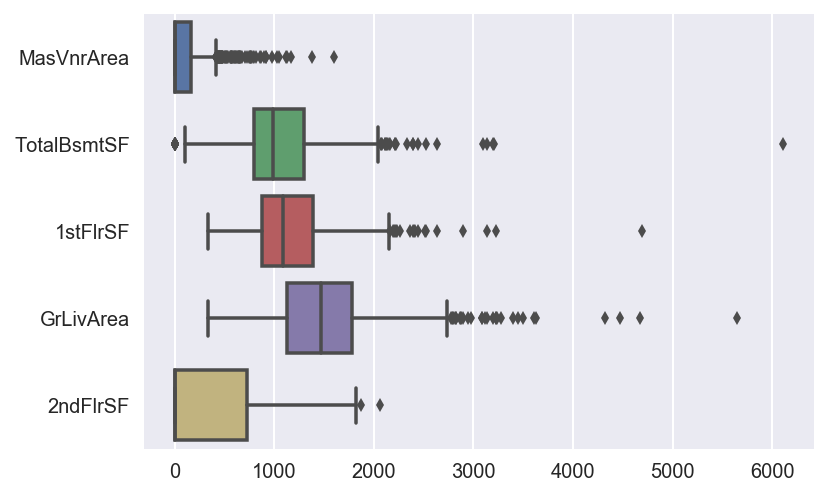

In [50]:
# plot boxplots of those with skewness > 0.5
box = df_fixed.loc[:, ('MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', '2ndFlrSF')]
sns.boxplot(data=box, orient='h')
plt.show()

# SET YrSold = 2010 AS HOLD-OUT SET. THE REMAINING AS TRAINING SET

In [51]:
## seperate categorical features from numerical
df_fixed.columns.to_series().groupby(df_fixed.dtypes).groups

{dtype('int64'): Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
        '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
        'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'YrSold'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'SalePrice'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'Foundation', 'BsmtExposure', 'GarageType', 'PavedDrive',
        'MiscFeature', 'SaleType', 'SaleCondition'],
       dtype='object')}

In [52]:
df_fixed_cat = df_fixed.loc[:,['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'Foundation', 'BsmtExposure', 'GarageType', 'PavedDrive',
        'MiscFeature', 'SaleType', 'SaleCondition']]
df_fixed_cat.head()

MSZoning Alley LotShape LandContour LotConfig LandSlope Neighborhood  \
0       RL   NaN      Reg         Lvl    Inside       Gtl      CollgCr   
1       RL   NaN      Reg         Lvl       FR2       Gtl      Veenker   
2       RL   NaN      IR1         Lvl    Inside       Gtl      CollgCr   
3       RL   NaN      IR1         Lvl    Corner       Gtl      Crawfor   
4       RL   NaN      IR1         Lvl       FR2       Gtl      NoRidge   

  Condition1 Condition2 BldgType      ...      Exterior1st Exterior2nd  \
0       Norm       Norm     1Fam      ...          VinylSd     VinylSd   
1      Feedr       Norm     1Fam      ...          MetalSd     MetalSd   
2       Norm       Norm     1Fam      ...          VinylSd     VinylSd   
3       Norm       Norm     1Fam      ...          Wd Sdng     Wd Shng   
4       Norm       Norm     1Fam      ...          VinylSd     VinylSd   

  MasVnrType Foundation BsmtExposure GarageType PavedDrive MiscFeature  \
0    BrkFace      PConc           No     Attchd          Y         NaN   
1        NaN     CBlock           Gd     Attchd          Y         NaN   
2    BrkFace      PConc           Mn     Attchd          Y         NaN   
3        NaN     BrkTil           No     Detchd          Y         NaN   
4    BrkFace      PConc           Av     Attchd          Y         NaN   

  SaleType SaleCondition  
0       WD        Normal  
1       WD        Normal  
2       WD        Normal  
3       WD       Abnorml  
4       WD        Normal  

[5 rows x 23 columns]

In [53]:
## choosing which ones to get_dummies and manually choose reference
## create empty dataframe
dummied = pd.DataFrame()

In [54]:
temp = pd.get_dummies(df_fixed_cat['MSZoning'])

In [55]:
## MSZoning - get dummies for this with nulls as reference
dummied = pd.concat([dummied, temp], axis=1)
dummied.head()

FV  RH  RL  RM
0   0   0   1   0
1   0   0   1   0
2   0   0   1   0
3   0   0   1   0
4   0   0   1   0

In [56]:
# convert YrSold to string
df_fixed['YrSold'] = df_fixed['YrSold'].astype(str)

In [57]:
# create dummy variables for categorical features
df_fixed = pd.get_dummies(df_fixed)

In [58]:
holdout = df_fixed[df_fixed['YrSold_2010'] == 1].drop(columns=['YrSold_2010', 'YrSold_2009', 'YrSold_2008',\
                                                               'YrSold_2007', 'YrSold_2006'])
training = df_fixed[df_fixed['YrSold_2010'] == 0].drop(columns=['YrSold_2010', 'YrSold_2009', 'YrSold_2008',\
                                                               'YrSold_2007', 'YrSold_2006'])
training = shuffle(training, random_state=42)

In [59]:
X_train = training.drop(columns='SalePrice')
y_train = training['SalePrice'].values

In [60]:
X_test = holdout.drop(columns='SalePrice')
y_test = holdout['SalePrice'].values

In [61]:
X_train.shape

(1278, 178)

In [62]:
X_test.shape

(172, 178)

# MODEL 1: Linear Regression

In [63]:
lreg = LinearRegression()

r_square = cross_val_score(lreg, X_train, y_train, cv=5)

print('Cross Validation r_squares: {}'.format(r_square))
print('Average r_square: {}'.format(r_square.mean()))
# after 10 rounds of cross validations, average R2 = 0.81

Cross Validation r_squares: [0.90837355 0.83898657 0.78126609 0.65587442 0.85732542]
Average r_square: 0.808365210332517


In [64]:
lreg = lreg.fit(X_train, y_train)

In [65]:
# lets see how well the model does on the unseen test set (YrSold=2010)
r_sq_holdout = lreg.score(X_test, y_test)
# mse = mean_squared_error(y_test, y_test_pred)

print('r_square of hold-out: {}'.format(r_sq_holdout))
# print('MSE of hold-out: {}'.format(mse))
# R2 of 0.88 is pretty decent

r_square of hold-out: 0.877535455769239


In [66]:
# predict y on hold-out set
y_test_pred = lreg.predict(X_test)

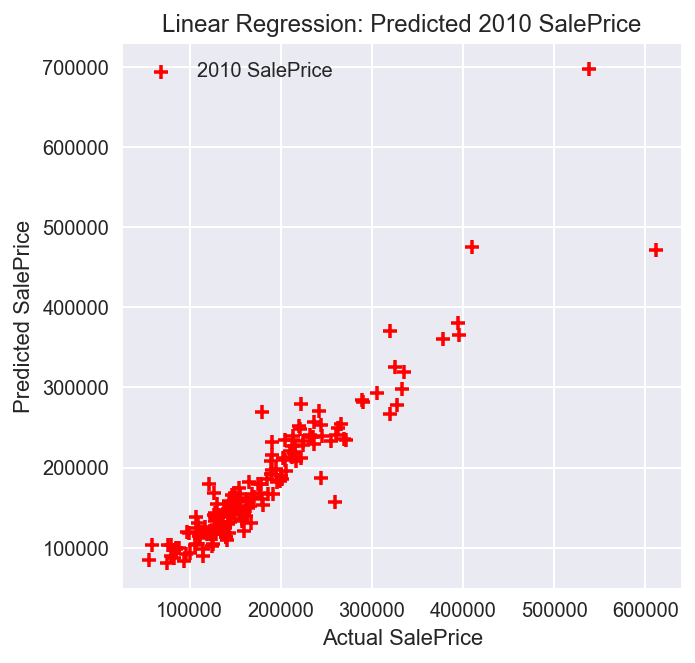

In [67]:
# inverse the log transformation on SalePrice and plot actual vs predicted SalePrice
plt.figure(figsize=(5,5))
# plt.scatter(np.exp(y_train), np.exp(y_train_pred),  c = "red", label = 'Pre-2010 SalePrice')
plt.scatter(np.exp(y_test), np.exp(y_test_pred), c = "red", marker = '+', label = '2010 SalePrice')
plt.title('Linear Regression: Predicted 2010 SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.legend(loc = "upper left")
plt.show()

# MODEL 2: Ridge Regression

In [68]:
# STEP 1a: Initialise StandardScaler as ss
ss = StandardScaler()

# STEP 1b: Fit X_train into ss and perform the transformation concurrently
Xs_train = ss.fit_transform(X_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [69]:
# STEP 2a: Specify range to search for optimal alpha
ridge_alphas = np.linspace(0, 1000, 2000)

# STEP 2b: Perform ridge cross validation on Xs_train/y_train across the specified alpha range
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5).fit(Xs_train, y_train)

# print optimal alpha
print(optimal_ridge.alpha_)

310.65532766383194


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [70]:
# STEP 3a: Perform cross validation using optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_train, y_train, cv=5)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.91008776 0.85019237 0.81395187 0.73870909 0.86514228]
0.8356166753128157


In [71]:
# STEP 4a: Fit data in ridge
ridge = ridge.fit(Xs_train, y_train)

# STEP 4b: Transform Xs_test USING PRE-FITTED StandardScaler
Xs_test = ss.transform(X_test)

# STEP 4c: See how well the ridge model scores in the 2010 data
ridge_test_score = ridge.score(Xs_test, y_test)
ridge_test_score

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


0.8852647572165152

In [72]:
# predict y on hold-out set
y_test_pred = ridge.predict(Xs_test)

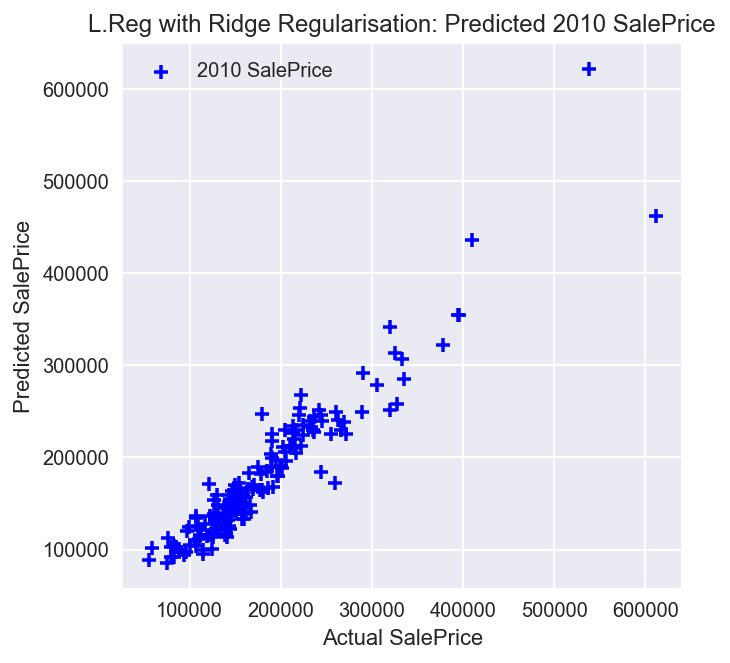

In [73]:
# inverse the log transformation on SalePrice and plot actual vs predicted SalePrice
plt.figure(figsize=(5,5))
# plt.scatter(np.exp(y_train), np.exp(y_train_pred),  c = "red", label = 'Pre-2010 SalePrice')
plt.scatter(np.exp(y_test), np.exp(y_test_pred), c = "blue", marker = '+', label = '2010 SalePrice')
plt.title('L.Reg with Ridge Regularisation: Predicted 2010 SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.legend(loc = "upper left")
plt.show()

# MODEL 3: Lasso Reg

In [74]:
# STEP 1a: Initialise StandardScaler as ss
ss = StandardScaler()

# STEP 1b: Fit X_train into ss and perform the transformation concurrently
Xs_train = ss.fit_transform(X_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [75]:
# STEP 2a: Perform Lasso cross validation on Xs_train/y_train across the specified alpha range
# lassocv automatically selects alphas
optimal_lasso = LassoCV(cv=5).fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

0.003166725392437452


In [76]:
# STEP 3a: Perform cross validation using optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=5)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.91621869 0.86331    0.79714562 0.69043089 0.8830844 ]
0.8300379192231828


In [77]:
# STEP 4a: Fit data in ridge
lasso.fit(Xs_train, y_train)

# STEP 4b: Transform Xs_test USING PRE-FITTED StandardScaler
Xs_test = ss.transform(X_test)

# STEP 4c: See how well the lasso model scores in the 2010 data
lasso_test_score = lasso.score(Xs_test, y_test)
lasso_test_score

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


0.8979201498723016

In [78]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

## MOST INFLUENTIAL 'FIXED' FEATURES:

In [79]:
lasso_coefs[lasso_coefs['abs_coef'] != 0]

variable      coef  abs_coef
8                GrLivArea  0.154772  0.154772
98        RoofMatl_ClyTile -0.067195  0.067195
5              TotalBsmtSF  0.056781  0.056781
3             YearRemodAdd  0.053807  0.053807
2                YearBuilt  0.050799  0.050799
13              GarageCars  0.033858  0.033858
53    Neighborhood_NridgHt  0.032567  0.032567
43    Neighborhood_Crawfor  0.030494  0.030494
9             BsmtFullBath  0.028487  0.028487
75         Condition2_PosN -0.027760  0.027760
14              GarageArea  0.023890  0.023890
1                  LotArea  0.021898  0.021898
59    Neighborhood_StoneBr  0.021823  0.021823
18             MSZoning_RM -0.017853  0.017853
109    Exterior1st_BrkFace  0.017418  0.017418
147        BsmtExposure_Gd  0.017312  0.017312
151      GarageType_Attchd  0.017228  0.017228
79           BldgType_1Fam  0.016874  0.016874
47    Neighborhood_MeadowV -0.016451  0.016451
81         BldgType_Duplex -0.015647  0.015647
108    Exterior1st_BrkComm -0.014915  0.014915
36           LandSlope_Sev -0.014820  0.014820
58    Neighborhood_Somerst  0.012996  0.012996
149        BsmtExposure_No -0.012661  0.012661
44    Neighborhood_Edwards -0.011787  0.011787
172  SaleCondition_Abnorml -0.011618  0.011618
156           PavedDrive_N -0.011300  0.011300
11                HalfBath  0.009932  0.009932
74         Condition2_PosA  0.009408  0.009408
4               MasVnrArea  0.009298  0.009298
..                     ...       ...       ...
73         Condition2_Norm  0.003573  0.003573
175   SaleCondition_Family -0.003547  0.003547
101         RoofMatl_Metal  0.003430  0.003430
63        Condition1_Feedr -0.003365  0.003365
88       HouseStyle_2.5Unf  0.003339  0.003339
139       MasVnrType_Stone  0.003203  0.003203
129    Exterior2nd_MetalSd  0.003021  0.003021
10                FullBath  0.002890  0.002890
111    Exterior1st_CemntBd  0.002733  0.002733
158           PavedDrive_Y  0.002716  0.002716
94       RoofStyle_Gambrel  0.002627  0.002627
117     Exterior1st_Stucco  0.002242  0.002242
60     Neighborhood_Timber  0.001698  0.001698
146        BsmtExposure_Av  0.001688  0.001688
27         LandContour_Low -0.001576  0.001576
85       HouseStyle_1.5Unf  0.001410  0.001410
31           LotConfig_FR2 -0.001288  0.001288
20              Alley_Pave  0.001259  0.001259
50    Neighborhood_NPkVill  0.001149  0.001149
25         LandContour_Bnk -0.000985  0.000985
145        Foundation_Wood -0.000918  0.000918
56     Neighborhood_Sawyer -0.000842  0.000842
26         LandContour_HLS  0.000630  0.000630
87       HouseStyle_2.5Fin -0.000627  0.000627
163           SaleType_COD -0.000486  0.000486
39     Neighborhood_BrDale -0.000328  0.000328
70         Condition1_RRNn  0.000280  0.000280
24            LotShape_Reg -0.000249  0.000249
116      Exterior1st_Stone  0.000165  0.000165
153     GarageType_BuiltIn  0.000133  0.000133

[87 rows x 3 columns]

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [80]:
# approach
# find residuals from model 1.
# freature selection of unfixed features
# use OLS because of interpretability
# find the highest coefficients and those features would be the one that influecnes the variances most
# how to use model 1 and 2? fromi model 1, find those that are undervalued. then run model 2 to find the largest coefficients


In [81]:
# get unfixed features
df_unfixed = df.loc[:, ('SalePrice', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond','BsmtCond','BsmtFinType1',
                        'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2','BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir',
                        'Electrical', 'LowQualFinSF','KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu',
                        'GarageYrBlt', 'GarageFinish','GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF',
                        'EnclosedPorch', '3SsnPorch','PoolQC', 'Fence')]
df_unfixed.shape

(1460, 30)

In [82]:
# target variable will be the residuals remaining from the first model

In [83]:
X_unfixed = df_unfixed.drop(columns='SalePrice')
y_unfixed = df_unfixed['SalePrice'].values

model = sm.OLS(X_unfixed, y_unfixed)
model = model.fit()
predictions = model.predict(X_unfixed)

# Plot the model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

print("MSE:", mean_squared_error(y, predictions))

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
model.summary()

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: